<a href="https://colab.research.google.com/github/asu-trans-ai-lab/Integrated_modeling_GMNS/blob/main/GMNS_AMS_ASU_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial will go through the traffic network modeling process using ASU network as an example.

The tutorial will cover the following steps:

*   OSM2GMNS: Downloading your OSM data and converting to GMNS format
*   GRID2DEMAND: Generating the zones and OD matrices
*   PATH4GMNS: Running DTA module of path4gmns

You can run step-by-step with this tutorial to get a quick overview of the program flow.

Before you start, make sure you have the following libraries installed and introduced into the programme:

In [1]:
!pip install pandas
!pip install osm2gmns
!pip install grid2demand
!pip install path4gmns

In [2]:
from __future__ import absolute_import
import pandas as pd
import osm2gmns as og
from grid2demand import GRID2DEMAND
import path4gmns as pg

osm2gmns, 0.7.3
grid2demand, version 0.3.9
path4gmns, version 0.9.8


The OSM2GMNS module allows you to download the desired area using the relation code, which can be obtained from the official [OpenStreetMap](https://www.openstreetmap.org/#map=18/33.42141/-111.93472&layers=DG) website. Alternatively, if you already have the OSM file, you can skip downloading the map and go straight to the conversion process.

In [3]:
og.downloadOSMData(3444656, 'asu.osm')
input_file = 'asu.osm'

valid reponses got from API server.
receving data...
map data has been written to asu.osm


Using the OSM data, the OSM2GMNS module generates the node and link files, and optionally the poi file as well. Moreover, the user is also allowed to change important parameters (such as mode types), which enables the user to customize their network data. Please refer to the [OSM2GMNS GitHub](https://github.com/asu-trans-ai-lab/OSM2GMNS) website for more details.

In [4]:
net = og.getNetFromFile(input_file,
                        network_types=('auto','bike','walk'),
                        POI=True,
                        POI_sampling_ratio=1,
                        strict_mode=False,
                        min_nodes=25,
                        default_lanes=True,
                        default_speed=True,
                        default_capacity=True,
                        start_node_id=0,
                        start_link_id=0)
default_lanes_dict = {'motorway': 4, 'trunk': 3, 'primary': 3, 'secondary': 2, 'tertiary': 2,
                      'residential': 1, 'service': 1, 'cycleway':1, 'footway':1, 'track':1,
                      'unclassified': 1, 'connector': 2}
default_speed_dict = {'motorway': 120, 'trunk': 100, 'primary': 80, 'secondary': 60, 'tertiary': 40,
                      'residential': 30, 'service': 30, 'cycleway':5, 'footway':5, 'track':30,
                      'unclassified': 30, 'connector':120}
default_capacity_dict = {'motorway': 2300, 'trunk': 2200, 'primary': 1800, 'secondary': 1600, 'tertiary': 1200,
                      'residential': 1000, 'service': 800, 'cycleway':800, 'footway':800, 'track':800,
                      'unclassified': 800, 'connector':9999}
og.connectPOIWithNet(net)
og.generateNodeActivityInfo(net)
og.outputNetToCSV(net)

arguments used for network parsing:
  filename: asu.osm
  network_types: ('auto', 'bike', 'walk')
  link_types: all
  POI: True
  POI_sampling_ratio: 1
  strict_mode: False
  offset: no
  min_nodes: 25
  combine: False
  bbox: None
  default_lanes: True
  default_speed: True
  default_capacity: True
  start_node_id: 0
  start_link_id: 0

Building Network from OSM file
  reading osm file
  parsing osm network
    generating nodes and links
    generating POIs
    removing sub networks with less than 25 nodes
  number of nodes: 2030, number of links: 3621, number of pois: 511
Generating Node Activity Information
Outputting Network Files


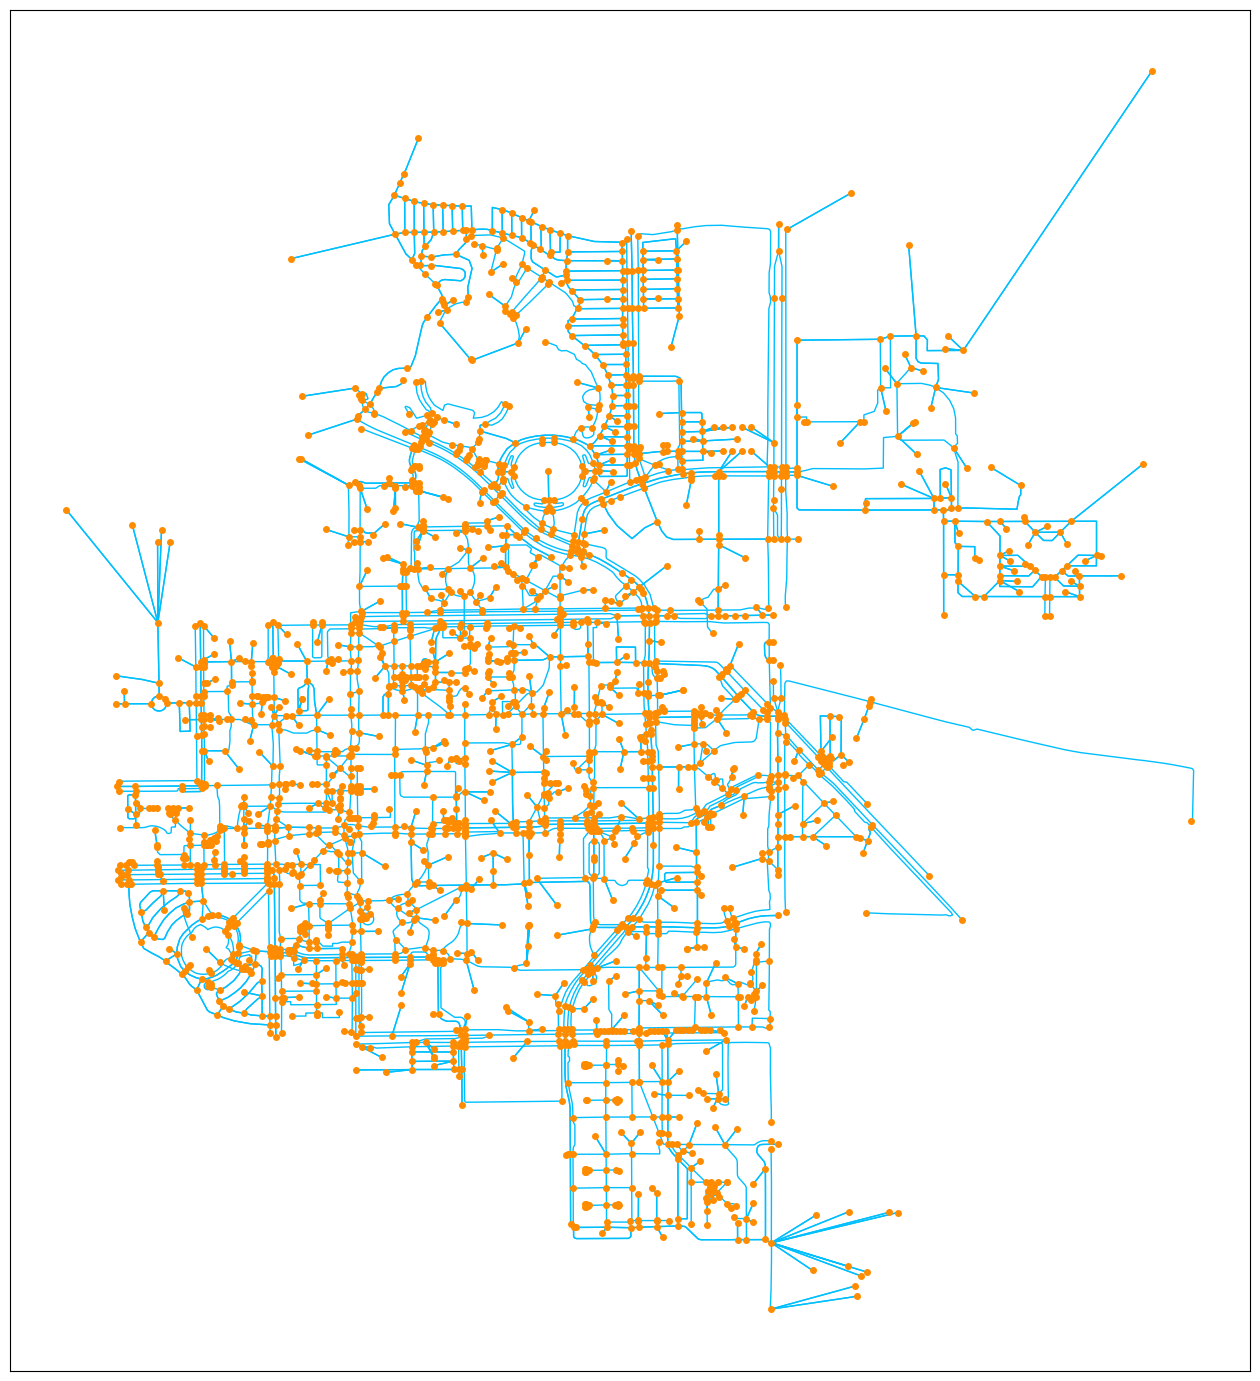

In [5]:
og.show(net)

The GRID2DEMAND module generates the zone and demand files using the node, link, and poi files. Please refer to the official [GRID2DEMAND GitHub](https://github.com/asu-trans-ai-lab/grid2demand) website for more details.

In [6]:
if __name__ == "__main__":

    # Specify the input directory, if working directory is not the default directory
    # input_dir = "place_holder"
    # gd = GRID2DEMAND(input_dir)

    gd = GRID2DEMAND()
    node_dict, poi_dict = gd.load_network.values()

    # Generate grids based on number of blocks in x and y directions
    zone_dict = gd.net2zone(node_dict, num_x_blocks=10, num_y_blocks=10)
    # Alternatively, grids can be generated by distance (kilometers)
    # zone_dict = gd.net2zone(node_dict, cell_width=10, cell_height=10)

    updated_dict = gd.sync_geometry_between_zone_and_node_poi(zone_dict, node_dict, poi_dict)
    zone_dict_update, node_dict_update, poi_dict_update = updated_dict.values()

    # Calculate zone-to-zone od distance matrix
    zone_od_distance_matrix = gd.calc_zone_od_distance_matrix(zone_dict_update)

    # Generate poi trip rate for each poi
    poi_trip_rate = gd.gen_poi_trip_rate(poi_dict_update)

    # Generate node production attraction for each node based on poi_trip_rate
    node_prod_attr = gd.gen_node_prod_attr(node_dict_update, poi_trip_rate)

    # Calculate zone production and attraction based on node production and attraction
    zone_prod_attr = gd.calc_zone_prod_attr(node_prod_attr, zone_dict_update)

    # Run gravity model to generate agent-based demand
    df_demand = gd.run_gravity_model(zone_prod_attr, zone_od_distance_matrix)

    # Generate agent-based demand
    df_agent = gd.gen_agent_based_demand(node_prod_attr, zone_prod_attr, df_demand=df_demand)

    # Step 9: Output demand, agent, zone, zone_od_dist_table, zone_od_dist_matrix files
    gd.save_demand
    gd.save_agent
    gd.save_zone
    gd.save_zone_od_dist_table
    gd.save_zone_od_dist_matrix

  : Input directory is not specified.                   Use current working directory /content as input directory.                   Please make sure node.csv and poi.csv are in /content.
  : Checking input directory...
  : input dir /content, traverse files by type: csv
  : Optional files: ['zone.csv'] are found in /content.
  : Optional files could be used in the following steps.
  : Input directory is valid.

  : Loading default package settings...
  : Package settings loaded successfully.

INFO Begin to run function: read_network …
  : input dir /content, traverse files by type: csv
INFO Begin to run function: read_node …
  : Parallel creating Nodes using Pool with 2 CPUs. Please wait...
  : Reading node.csv with specified columns: ['node_id', 'x_coord', 'y_coord', 'activity_type', 'is_boundary', 'poi_id']                 
    and chunksize 10000 for iterations...
  : Successfully loaded node.csv: 2541 Nodes loaded.
INFO Finished running function: read_node, total: 0s

INFO Begin t

The final step is running the DTA component from the PATH4GMNS module and produces important results (such as link_performance) from all the previously obtained files. Please refer to the official [DTALite GitHub](https://github.com/asu-trans-ai-lab/DTALite) website for more details.

In [ ]:
node = pd.read_csv('node.csv')
link = pd.read_csv('link.csv')
demand = pd.read_csv('demand.csv')

In [ ]:
# CAUTION: Colabs will sometimes crash when DTALite is run. It is recommended to run this on your system.
pg.run_DTALite()